In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output

In [ ]:

class GridWorldEnv(gym.Env):
    def __init__(self,grid, size=5):
        super(GridWorldEnv, self).__init__()
        self.size = size
        self.action_space = gym.spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = gym.spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32)
        self.max_steps = 200
        self.grid = grid

        self.reset()

        # Define colors for different states
        self.colors = ['white', 'lightgreen', 'lightblue']  # normal, grass, snowy
        self.cmap = ListedColormap(self.colors)

        # Create a figure and axis for rendering
        # self.fig, self.ax = plt.subplots()

    def reset(self):
        self.agent_pos = np.random.randint(0, self.size, size=2)
        self.goal_pos = [self.size-1, self.size-1]
        self.current_step = 0
        return self._get_observation()
    def step(self, action):
        agent_id=self.agent_id
        self.current_step += 1

        # Move agent
        if action == 0:  # Up
            self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1:  # Down
            self.agent_pos[0] = min(self.size - 1, self.agent_pos[0] + 1)
        elif action == 2:  # Left
            self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3:  # Right
            self.agent_pos[1] = min(self.size - 1, self.agent_pos[1] + 1)

        # Check if goal is reached
        done = np.array_equal(self.agent_pos, self.goal_pos)

        # Calculate reward
        x, y = self.agent_pos
        if done:
            reward = 10

        else:
          if self.grid[x, y] == 0:
            reward = -1
          elif self.grid[x, y] == 1:
            reward = -2
          elif self.grid[x, y] == 2:
            reward = -3

        return self._get_observation(), reward, done or self.current_step >= self.max_steps, {}
    def _get_observation(self):
        return self.agent_pos.copy()

    def render(self, mode='human'):
        if mode == 'human':
            self.ax.clear()  # Clear the previous plot
            self.ax.imshow(self.grid, cmap=self.cmap, vmin=0, vmax=2)
            self.ax.plot(self.agent_pos[1], self.agent_pos[0], 'ro', markersize=10)
            self.ax.plot(self.goal_pos[1], self.goal_pos[0], 'go', markersize=10)
            self.ax.set_title(f'Step: {self.current_step}')
            self.ax.axis('off')
            plt.draw()
            plt.pause(0.1)

    def close(self):
        plt.close(self.fig)


class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return F.softmax(self.fc(x), dim=-1)

class Agent:
    def __init__(self, input_size, output_size, states_properties, render=False):
        self.policy = PolicyNetwork(input_size , output_size)  # Multiply by 2 to account for state mask
        self.optimizer = optim.Adam(self.policy.parameters(), lr=0.001)
        self.states_properties = states_properties
        self.recent_rewards = []
        self.render = render

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state)  # Add this line

        probs = self.policy(state_tensor)

        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)

        return action.item(), log_prob

    def train(self, env, num_episodes):
        for episode in range(num_episodes):
            state = env.reset()
            log_probs = []
            rewards = []
            done = False
            true_rew=[]

            while not done:
                action, log_prob = self.select_action(state)
                next_state, reward, done, _ = env.step(action)

                # Adjust reward based on agents knowledge
                x, y = state
                rew=reward
                if env.grid[x, y] not in self.states_properties:
                  rew = -10
                log_probs.append(log_prob)
                rewards.append(reward)
                true_rew.append(rew)
                state = next_state

            self.recent_rewards.append(np.mean(true_rew))

            # Update policy
            returns = self._compute_returns(rewards)
            policy_loss = 0
            for log_prob, R in zip(log_probs, returns):
                policy_loss += -log_prob * R
            self.optimizer.zero_grad()
            policy_loss.backward()
            self.optimizer.step()

    def _compute_returns(self, rewards, gamma=0.99):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def get_policy_params(self):
        return {name: param.data.clone() for name, param in self.policy.named_parameters()}

    def get_recent_rewards(self):
        return self.recent_rewards
import numpy as np
import torch
import torch.nn.functional as F


class AdaptiveConfidenceWeightedAggregator:
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.confidence_factors = [1.0] * num_agents

    def aggregate_policies(self, agent_policies, agent_rewards):
        # Update confidence factors based on agent performance
        total_reward = sum(np.exp(np.mean(rewards)) for rewards in agent_rewards)
        self.confidence_factors = [np.exp(np.mean(rewards))/ total_reward for rewards in agent_rewards]

        # Aggregate policies using confidence factors
        aggregated_policy = {}
        for param_name in agent_policies[0].keys():
            weighted_params = [cf * policy[param_name] for cf, policy in zip(self.confidence_factors, agent_policies)]
            aggregated_policy[param_name] = sum(weighted_params) / sum(self.confidence_factors)

        return aggregated_policy

    def get_confidence_factors(self):
        return self.confidence_factors

class FedAvg:
    def __init__(self, num_agents):
        self.num_agents = num_agents

    def aggregate_policies(self, agent_policies, agent_rewards):
        aggregated_policy = {}
        for param_name in agent_policies[0].keys():
            aggregated_policy[param_name] = sum(policy[param_name] for policy in agent_policies) / self.num_agents
        return aggregated_policy
    def get_confidence_factors(self):
        return None

class FedProx:
    def __init__(self, num_agents, mu=0.01):
        self.num_agents = num_agents
        self.mu = mu  # Proximal term coefficient

    def aggregate_policies(self, agent_policies, agent_rewards, global_policy):
        aggregated_policy = {}
        for param_name in agent_policies[0].keys():
            avg_param = sum(policy[param_name] for policy in agent_policies) / self.num_agents
            proximal_term = self.mu * (global_policy[param_name] - avg_param)
            aggregated_policy[param_name] = avg_param + proximal_term
        return aggregated_policy

    def get_confidence_factors(self):
        return None

class CentralServer:
    def __init__(self, input_size, output_size, num_agents, aggregator_type='ACWPA'):
        self.global_policy = PolicyNetwork(input_size, output_size)
        self.num_agents = num_agents
        if aggregator_type == 'ACWPA':
            self.aggregator = AdaptiveConfidenceWeightedAggregator(num_agents)
        elif aggregator_type == 'FedAvg':
            self.aggregator = FedAvg(num_agents)
        elif aggregator_type == 'FedProx':
            self.aggregator = FedProx(num_agents)
        self.confidence_factors_history = []
        self.aggregator_type = aggregator_type

    def aggregate_policies(self, agents):
        agent_policies = [agent.get_policy_params() for agent in agents]
        agent_rewards = [agent.get_recent_rewards() for agent in agents]

        if self.aggregator_type == 'ACWPA':
            aggregated_policy = self.aggregator.aggregate_policies(agent_policies, agent_rewards)
        elif self.aggregator_type == 'FedAvg':
            aggregated_policy = self.aggregator.aggregate_policies(agent_policies, agent_rewards)
        elif self.aggregator_type == 'FedProx':
            global_policy = self.global_policy.state_dict()
            aggregated_policy = self.aggregator.aggregate_policies(agent_policies, agent_rewards, global_policy)

        if hasattr(self.aggregator, 'get_confidence_factors'):
            self.confidence_factors_history.append(self.aggregator.get_confidence_factors())

        self.global_policy.load_state_dict(aggregated_policy)

    def simple_average(self, agent_policies):
        averaged_policy = {}
        for param_name in agent_policies[0].keys():
            averaged_policy[param_name] = sum(policy[param_name] for policy in agent_policies) / len(agent_policies)
        return averaged_policy

    def distribute_global_policy(self, agents):
        for agent in agents:
            agent.policy.load_state_dict(self.global_policy.state_dict())

    def get_confidence_factors(self):
        return self.aggregator.get_confidence_factors() if hasattr(self.aggregator, 'get_confidence_factors') else None




def create_agents(num_agents, input_size, output_size, states_properties):
    agents = []

    for i in range(num_agents):
      agent = Agent(input_size, output_size, states_properties[i])
      agents.append(agent)
    return agents

def evaluate_global_policy(policy, env, num_episodes, input_size=2):
    total_reward = 0
    total_reward1=0
    total_reward2=0
    for _ in range(num_episodes):
        state = env.reset()
        done = False

        episode_reward = []
        step = 0

        while not done:

            state_tensor = torch.FloatTensor(state)
            action = torch.argmax(policy(state_tensor)).item()
            next_state, reward, done, _ = env.step(action)

            episode_reward.append(reward)
            state = next_state
            step += 1

        total_reward += np.mean(episode_reward)
    return total_reward / num_episodes

def run_multiple_trials(num_trials, env, num_rounds, num_episodes_per_round, num_agents, states_properties):
    all_results = {
        'ACWPA': {'global_rewards': []},
        'FedAvg': {'global_rewards': []},
        'FedProx': {'global_rewards': []}
    }

    for trial in range(num_trials):
        print(f"Running trial {trial + 1}/{num_trials}")
        trial_results = run_federated_learning(env, num_rounds, num_episodes_per_round, num_agents, states_properties)

        for aggregator_type in ['ACWPA', 'FedAvg', 'FedProx']:
            all_results[aggregator_type]['global_rewards'].append(trial_results[aggregator_type]['global_rewards'])

    return all_results


def calculate_performance_metrics(all_results):
    performance_metrics = {}

    for aggregator_type in ['ACWPA', 'FedAvg', 'FedProx']:
        global_rewards = np.array(all_results[aggregator_type]['global_rewards'])
        avg_performance = np.mean(global_rewards[:, -1])  # Take the last episode's reward
        std_performance = np.std(global_rewards[:, -1])

        performance_metrics[aggregator_type] = {
            'avg_performance': avg_performance,
            'std_performance': std_performance
        }

    return performance_metrics


def plot_results(results):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    aggregator_types = ['ACWPA','FedAvg', 'FedProx']

    for i, aggregator_type in enumerate(aggregator_types):
        global_rewards = results[aggregator_type]['global_rewards']
        agent_rewards = results[aggregator_type]['agent_rewards']
        mean_agent_rewards = []
        for agent_reward in agent_rewards:
            mean_agent_reward = [np.mean(agent_reward[:j+1]) for j in range(len(agent_reward))]
            mean_agent_rewards.append(mean_agent_reward)

        mean_global_reward = [np.mean(global_rewards[:j+1]) for j in range(len(global_rewards))]

        confidence_factors_history = results[aggregator_type]['confidence_factors_history']

        # Plot rewards
        ax = axes[i // 2, i % 2]
        ax.plot(mean_global_reward, label='Federated',linewidth=4.0)
        for j, rewards in enumerate(mean_agent_rewards):
            ax.plot(rewards, label=f'Agent {j+1}',linewidth=4)
        ax.set_xlabel('Episodes')
        ax.set_ylabel('Average Reward')
        ax.set_title(f'{aggregator_type} - Agent Rewards vs Federated Rewards')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot global rewards comparison
    plt.figure(figsize=(10, 6))
    for aggregator_type in aggregator_types:
        global_rewards = results[aggregator_type]['global_rewards']
        mean_global_reward = [np.mean(global_rewards[:j+1]) for j in range(len(global_rewards))]
        plt.plot(mean_global_reward, label=aggregator_type,linewidth=4)
    plt.xlabel('Episodes')
    plt.ylabel('Average Global Reward')
    plt.title('Comparison of Global Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()


def run_federated_learning(env, num_rounds, num_episodes_per_round, num_agents, states_properties):
    input_size = 2  # [x, y]
    output_size = 4  # Up, Down, Left, Right

    results = {}

    for aggregator_type in ['ACWPA', 'FedAvg', 'FedProx']:
        print(f"Starting training with {aggregator_type} aggregator")
        agents = create_agents(num_agents, input_size, output_size, states_properties)
        fully_familiar_agent = agents[-1]
        federated_agents = agents[:-1]

        central_server = CentralServer(input_size, output_size, num_agents - 1, aggregator_type)

        global_rewards = []
        agent_rewards = [[] for _ in agents]

        for round in range(num_rounds):
            print(f"{aggregator_type} - Round {round + 1}/{num_rounds}")

            # Local training
            for i, agent in enumerate(federated_agents):
                env.agent_id = i
                agent.recent_rewards = []
                agent.train(env, num_episodes_per_round)
                agent_rewards[i].append(np.mean(agent.recent_rewards))
                print(f"Agent {i+1} average reward: {agent_rewards[i][-1]:.2f}")

            # Train fully familiar agent separately
            fully_familiar_agent.train(env, num_episodes_per_round)
            agent_rewards[-1].append(np.mean(fully_familiar_agent.recent_rewards))
            print(f"Fully familiar agent average reward: {agent_rewards[-1][-1]:.2f}")

            # Policy aggregation and distribution
            central_server.aggregate_policies(federated_agents)
            central_server.distribute_global_policy(federated_agents)

            # Evaluate global policy
            env.agent_id = 2
            global_reward = evaluate_global_policy(central_server.global_policy, env, num_episodes_per_round, input_size)
            global_rewards.append(global_reward)

            print(f"Global Reward: {global_reward:.2f}")
            #if central_server.get_confidence_factors():
             #   print(f"Confidence Factors: {central_server.get_confidence_factors()}")
            print("-------------------------")

        results[aggregator_type] = {
            'global_rewards': global_rewards,
            'agent_rewards': agent_rewards,
            'confidence_factors_history': central_server.confidence_factors_history if central_server.confidence_factors_history else None
        }

    return results

import matplotlib.pyplot as plt

def plot_learning_curves(all_results):
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r']

    for i, (aggregator_type, color) in enumerate(zip(['ACWPA', 'FedAvg', 'FedProx'], colors)):
        global_rewards = np.array(all_results[aggregator_type]['global_rewards'])
        mean_rewards = np.mean(global_rewards, axis=0)
        std_rewards = np.std(global_rewards, axis=0)

        episodes = range(1, len(mean_rewards) + 1)
        plt.plot(episodes, mean_rewards, color=color, label=aggregator_type)
        plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, color=color, alpha=0.2)

    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Learning Curves for Different Aggregation Methods')
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
Global Reward: 0.24
-------------------------
FedAvg - Round 23/50
Agent 1 average reward: -3.22
Agent 2 average reward: -4.12
Fully familiar agent average reward: -1.28
Global Reward: 0.92
-------------------------
FedAvg - Round 24/50
Agent 1 average reward: -2.72
Agent 2 average reward: -3.71
Fully familiar agent average reward: -1.29
Global Reward: -0.56
-------------------------
FedAvg - Round 25/50
Agent 1 average reward: -3.05
Agent 2 average reward: -3.31
Fully familiar agent average reward: -1.31
Global Reward: 0.31
-------------------------
FedAvg - Round 26/50
Agent 1 average reward: -2.13
Agent 2 average reward: -4.45
Fully familiar agent average reward: -1.32
Global Reward: -0.12
-------------------------
FedAvg - Round 27/50
Agent 1 average reward: -3.87
Agent 2 average reward: -4.12
Fully familiar agent average reward: -1.34
Global Reward: -0.19
-------------------------
FedAvg - Round 28/50
Agent 1 average reward: -3.35

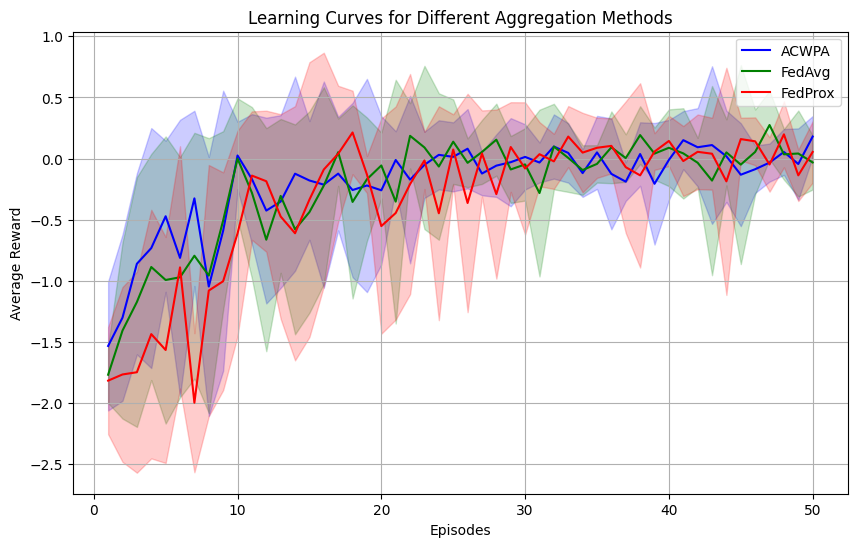

In [ ]:


# Set up the environment and parameters
num_agents = 3
num_rounds = 50
num_episodes_per_round = 50
size = 10
num_trials = 10  # Number of trials to run

grid = np.random.choice([0, 1, 2], size=(size, size))  # 0: normal, 1: grass, 2: snowy
env = GridWorldEnv(grid, size)

states_properties = [[0,1], [0,2], [0,1,2]]
res=3
if res==1:
  results = run_federated_learning(env, num_rounds, num_episodes_per_round, num_agents, states_properties)
  plot_results(results)
elif res==2:
  # Run multiple trials
  all_results = run_multiple_trials(num_trials, env, num_rounds, num_episodes_per_round, num_agents, states_properties)

  # Calculate performance metrics
  performance_metrics = calculate_performance_metrics(all_results)

  # Print results in a format similar to Table 1
  print("\nResults (Average Performance ± Standard Deviation):")
  print("-" * 50)
  print("Method    | Performance")
  print("-" * 50)
  for method, metrics in performance_metrics.items():
      print(f"{method:<9} | {metrics['avg_performance']:.2f} ± {metrics['std_performance']:.2f}")
  print("-" * 50)

  # After calculating performance metrics, call the plotting function
  plot_learning_curves(all_results)


elif res==3:

  results = run_federated_learning(env, num_rounds, num_episodes_per_round, num_agents, states_properties)
  plot_results(results)
  # Run multiple trials
  all_results = run_multiple_trials(num_trials, env, num_rounds, num_episodes_per_round, num_agents, states_properties)

  # Calculate performance metrics
  performance_metrics = calculate_performance_metrics(all_results)

  # Print results in a format similar to Table 1
  print("\nResults (Average Performance ± Standard Deviation):")
  print("-" * 50)
  print("Method    | Performance")
  print("-" * 50)
  for method, metrics in performance_metrics.items():
      print(f"{method:<9} | {metrics['avg_performance']:.2f} ± {metrics['std_performance']:.2f}")
  print("-" * 50)

  # After calculating performance metrics, call the plotting function
  plot_learning_curves(all_results)